In [1]:
import os
os.environ['THEANO_FLAGS'] = 'device=gpu, floatX=float32'

In [142]:
import ssn
# import rf_layer_norm as rf
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import time
import cPickle as pickle

from theano import *
import theano.tensor as T

%matplotlib inline

In [4]:
# define symbolic variables for theano
dt = T.scalar('dt', dtype='float32')
c = T.scalar("c", dtype='float32')
h = T.matrix("h", dtype='float32')
n_E = T.matrix("n_E", dtype='float32')
n_I = T.matrix("n_I", dtype='float32')
W_EE = T.tensor3("W_EE", dtype='float32')
W_EI = T.tensor3("W_EI", dtype='float32')
W_IE = T.tensor3("W_IE", dtype='float32')
W_II = T.tensor3("W_II", dtype='float32')
k = T.matrix("k", dtype='float32')
tau_E = T.matrix("tau_E", dtype='float32')
tau_I = T.matrix("tau_I", dtype='float32')

I_E = T.matrix('I_E', dtype='float32')
I_I = T.matrix('I_I', dtype='float32')

I_thresh_E = T.matrix('I_thresh_E', dtype='float32')
I_thresh_I = T.matrix('I_thresh_I', dtype='float32')

r_SS_E = T.matrix('r_SS_E', dtype='float32')
r_SS_I = T.matrix('r_SS_I', dtype='float32')

r_e = T.matrix("r_e", dtype='float32')
r_i = T.matrix("r_i", dtype='float32')

# initial firing rates are all zero
r_E = theano.shared(np.zeros((75,75), dtype='float32'))
r_I = theano.shared(np.zeros((75,75), dtype='float32'))

# Compile functions:
I_E = c*h + T.sum(T.sum(W_EE*r_e,1),1).reshape((75,75)).T - T.sum(T.sum(W_EI*r_i,1),1).reshape((75,75)).T
I_I = c*h + T.sum(T.sum(W_IE*r_e,1),1).reshape((75,75)).T - T.sum(T.sum(W_II*r_i,1),1).reshape((75,75)).T

I_thresh_E = T.switch(T.lt(I_E,0), 0, I_E)
I_thresh_I = T.switch(T.lt(I_I,0), 0, I_I)

r_SS_E = k*T.pow(I_thresh_E, n_E)
r_SS_I = k*T.pow(I_thresh_I, n_I)

euler_E = r_e + dt*(-r_e+r_SS_E)/tau_E
euler_I = r_i + dt*(-r_i+r_SS_I)/tau_I

euler = theano.function(inputs=[dt,c,h,W_EE,W_EI,W_IE,W_II,n_E,n_I,k,tau_E,tau_I], 
                            outputs=[r_E, r_I],
                            givens={r_e:r_E, r_i:r_I},
                            updates=[(r_E,euler_E), (r_I,euler_I)],
                            allow_input_downcast=True)

In [7]:
# load Blasdel orientation and ocular dominance maps (previously processed,
# see map_analysis.ipynb
st = time.time()
[OD_map_full, OP_map_full] = np.load('saved_vars/maps-Nov-13.p', 'rb')
print "Elapsed time to load maps: %d seconds" % (time.time() - st)
OD_map = OD_map_full[-75:,-75:]
OP_map = np.floor(OP_map_full[-75:,-75:])

Elapsed time to load maps: 0 seconds


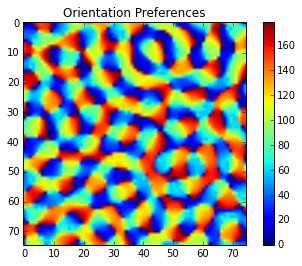

In [8]:
# Alternatively, load OP map from Bryan's extracted Kaschube map
data = scipy.io.loadmat('orientation-map.mat')
OP_map = np.floor(data['map'])
plt.imshow(OP_map)
plt.colorbar()
plt.title('Orientation Preferences', fontsize=14)
plt.savefig('thesis_results/orientation_map_ssn.png', format='png', dpi=50))

In [ ]:
# Generate LIF-based RF Layer:
import rf_layer_LIF as rf_lif
reload(rf_lif)
start_time = time.time()
RF_layer = rf_lif.rf_layer(OP_map, N_pairs=75, field_size=75, pix_deg=55)
print "Elapsed time to produce RF layer: %d seconds" % (time.time()-start_time)

In [10]:
# Generate SSN:
ss_net = ssn.SSNetwork(ori_map=OP_map, ocd_map=OD_map)

c0 = 40
dt0 = 0.005
timesteps = 100
dx = ss_net.dx
N_pairs = ss_net.N_pairs

# Cast SSN variables to float32 for Theano:
W_EE0 = ss_net.W_EE.astype('float32')
W_EI0 = ss_net.W_EI.astype('float32')
W_IE0 = ss_net.W_IE.astype('float32')
W_II0 = ss_net.W_II.astype('float32')

k0 = ss_net.k.astype('float32')
n_E0 = ss_net.n_E.astype('float32')
n_I0 = ss_net.n_I.astype('float32')

tau_E0 = ss_net.tau_E.astype('float32')
tau_I0 = ss_net.tau_I.astype('float32')

In [11]:
# Select some random SSN units to probe:
n_units = 40
r_units = np.floor(N_pairs*np.random.rand(n_units,2))

dt0 = 0.005
timesteps = 100

In [143]:
filename = 'saved_vars/integrated_model_ssn-dec-9.p'
start_time = time.time()
pickle.dump([ss_net, r_units], open(filename, 'wb'))
print "Elapsed time to pickle: ", time.time()-start_time

Elapsed time to pickle:  153.210273981


In [48]:
contrast_range_ssn = np.linspace(3,50,10)
contrast_range_rf = np.linspace(0.05,1,10)
ff_ssn_stim = np.zeros((len(r_units), N_pairs, N_pairs))
ff_rf_stim  = np.zeros((len(r_units), len(contrast_range_ssn), N_pairs, N_pairs))

ssn_contrast_results = np.zeros((len(r_units), len(contrast_range_ssn), 2, N_pairs, N_pairs))
rf_contrast_results  = np.zeros((len(r_units), len(contrast_range_rf), 2, N_pairs, N_pairs))

for i in range(len(r_units)):
    xi = r_units[i,0]
    yi = r_units[i,1]
    ff_ssn_stim[i,:,:] = ssn.generate_mono_stimulus(OP_map[yi,xi], 1, [xi*dx, yi*dx], OP_map, full_frame=True )
    for j in range(len(contrast_range_rf)):
        raw_img = rf_lif.generate_static_grating(OP_map[yi,xi]*np.pi/180, 75., 4*75, pix_deg=55, contrast=contrast_range_rf[j],phi=0)
        ff_rf_stim[i,j,:,:] = RF_layer.get_layer_response_rates(raw_img, phase_invariant=True)
        

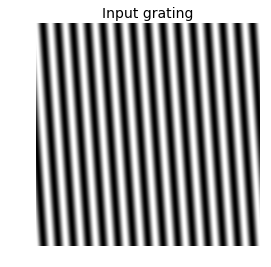

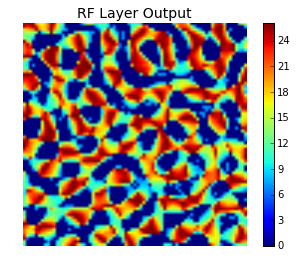

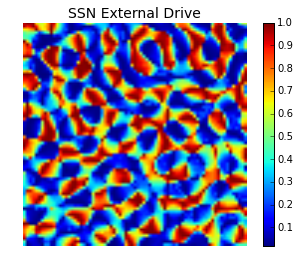

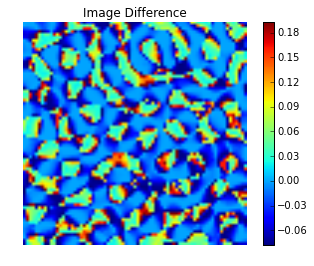

In [56]:
test_img = rf_lif.generate_static_grating(0, 75., 4*75, pix_deg=55, phi=0)
test_resp = RF_layer.get_layer_response_rates(0.5*test_img, phase_invariant=True)
ssn_img = ssn.generate_mono_stimulus(0, 1, [xi*dx, yi*dx], OP_map, full_frame=True )

plt.figure()
plt.imshow(rf_lif.generate_static_grating(np.pi/45, 75., .2*75, pix_deg=55, phi=0), cmap='gray')
plt.title('Input grating', fontsize=14)
plt.axis('off')
plt.savefig('thesis_results/raw_img_sample.png', format='png', dpi=100)
           
plt.figure()
plt.imshow(test_resp)
plt.title('RF Layer Output', fontsize=14)
plt.axis('off')
plt.colorbar()
plt.savefig('thesis_results/rf_output_sample.png', format='png', dpi=100)

plt.figure()
plt.imshow(ssn_img)
plt.title('SSN External Drive', fontsize=14)
plt.colorbar()
plt.axis('off')
plt.savefig('thesis_results/ssn_external_sample.png', format='png', dpi=100)

plt.figure()
plt.imshow(ssn_img-test_resp/np.max(test_resp))
plt.title("Image Difference")
plt.colorbar()
plt.axis('off')
plt.savefig('thesis_results/img_diff.png', format='png', dpi=100)

<matplotlib.colorbar.Colorbar instance at 0x7fa410c43e60>

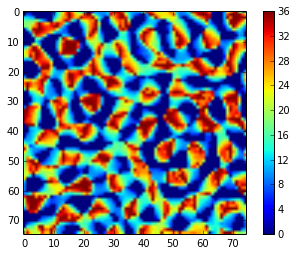

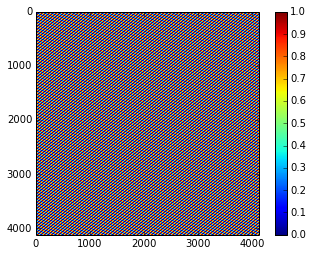

In [57]:
plt.figure()
plt.imshow(ff_rf_stim[1,-1])
plt.colorbar()

plt.figure()
plt.imshow(raw_img)
plt.colorbar()

In [58]:
# run simulations for figure 6B - system transition with contrast for both RF and SSN systems
# RF only:
start_time= time.time()
c0 = 1
for i in range(len(r_units)):
    for j in range(len(contrast_range_rf)):
        h0 = ff_rf_stim[i,j,:,:]
        for t in range(timesteps):
            euler(dt0,c0,h0,W_EE0,W_EI0,W_IE0,W_II0,n_E0,n_I0,k0,tau_E0,tau_I0)
        
        rf_contrast_results[i,j,0] = r_E.get_value()
        rf_contrast_results[i,j,1] = r_I.get_value()
        r_E.set_value(np.zeros((N_pairs,N_pairs),dtype='float32'))
        r_I.set_value(np.zeros((N_pairs,N_pairs),dtype='float32'))
        
print "Elapsed time: %d seconds." % (time.time()-start_time)

Elapsed time: 4131 seconds.


In [ ]:
# plot reproductions of figure 6B: RF only
rf_E_external = np.zeros((len(r_units), len(contrast_range_rf)))
rf_I_external = np.copy(rf_E_external)
rf_E_network = np.copy(rf_E_external)
rf_I_network = np.copy(rf_E_external)

for i in range(len(r_units)):
    xi = r_units[i,0]
    yi = r_units[i,1]
    for j in range(len(contrast_range_rf)):
        rf_E_network[i,j] = np.sum(rf_contrast_results[i,j,0]*ss_net.W_EE[yi+xi*N_pairs,:,:] + rf_contrast_results[i,j,1]*ss_net.W_EI[yi+xi*N_pairs,:,:])
        rf_I_network[i,j] = np.sum(rf_contrast_results[i,j,0]*ss_net.W_IE[yi+xi*N_pairs,:,:] + rf_contrast_results[i,j,1]*ss_net.W_II[yi+xi*N_pairs,:,:])
        rf_E_external[i,j] = np.sum(ff_rf_stim[i,j,yi,xi])
        
rf_external_avg = np.mean(rf_E_external,0)
rf_E_net_avg = np.mean(rf_E_network,0)
rf_I_net_avg = np.mean(rf_I_network,0)


plt.figure(figsize=(8, 6))
plt.plot(contrast_range_rf*100, 100*rf_external_avg/(rf_E_net_avg+rf_external_avg), 'r--', linewidth=2, label="External")
plt.plot(contrast_range_rf*100, 100*rf_external_avg/(rf_I_net_avg+rf_external_avg), 'b--', linewidth=2, label="External")
plt.plot(contrast_range_rf*100, 100*rf_E_net_avg/(rf_E_net_avg+rf_external_avg), 'r', linewidth=2, label="Network")
plt.plot(contrast_range_rf*100, 100*rf_I_net_avg/(rf_I_net_avg+rf_external_avg), 'b', linewidth=2, label="Network")

plt.title('SSN Transition - RF Layer input',fontsize=14)
plt.xlabel('Contrast (%)', fontsize=12)
plt.ylabel('Percent of Input', fontsize=12)
plt.tick_params(axis='x', labelsize=10)
plt.tick_params(axis='y', labelsize=10)
plt.legend(fontsize=12)
plt.savefig('thesis_results/integrated_transition.eps', format='eps', dpi=1000)

In [30]:
# run simulations for figure 6B - system transition with contrast for both RF and SSN systems
# SSN only:
start_time= time.time()

for i in range(len(r_units)):
    for j in range(len(contrast_range_ssn)):
        xi = r_units[i,0]
        yi = r_units[i,1]
        c0 = contrast_range_ssn[j]
        h0 = ff_ssn_stim[i,:,:]
        for t in range(timesteps):
            euler(dt0,c0,h0,W_EE0,W_EI0,W_IE0,W_II0,n_E0,n_I0,k0,tau_E0,tau_I0)
        ssn_contrast_results[i,j,0] = r_E.get_value()
        ssn_contrast_results[i,j,1] = r_I.get_value()
        r_E.set_value(np.zeros((N_pairs,N_pairs),dtype='float32'))
        r_I.set_value(np.zeros((N_pairs,N_pairs),dtype='float32'))
        
print "Elapsed time: %d seconds." % (time.time()-start_time)

Elapsed time: 1055 seconds.


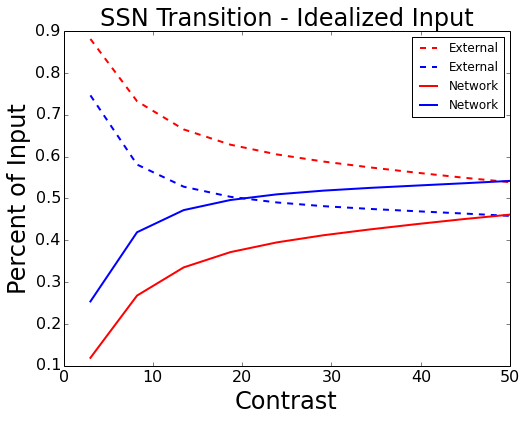

In [31]:
# plot reproductions of figure 6B: SSN only

ssn_E_external = np.zeros((len(r_units), len(contrast_range_ssn)))
ssn_I_external = np.copy(ssn_E_external)
ssn_E_network = np.copy(ssn_E_external)
ssn_I_network = np.copy(ssn_E_external)

for i in range(len(r_units)):
    xi = r_units[i,0]
    yi = r_units[i,1]
    for j in range(len(contrast_range_ssn)):
        ssn_E_network[i,j] = np.sum(ssn_contrast_results[i,j,0]*ss_net.W_EE[yi+xi*N_pairs,:,:] + ssn_contrast_results[i,j,1]*ss_net.W_EI[yi+xi*N_pairs,:,:])
        ssn_I_network[i,j] = np.sum(ssn_contrast_results[i,j,0]*ss_net.W_IE[yi+xi*N_pairs,:,:] + ssn_contrast_results[i,j,1]*ss_net.W_II[yi+xi*N_pairs,:,:])
        ssn_E_external[i,j] = np.sum(ff_ssn_stim[i,yi,xi]*contrast_range_ssn[j])
        
ssn_external_avg = np.mean(ssn_E_external,0)
ssn_E_net_avg = np.mean(ssn_E_network,0)
ssn_I_net_avg = np.mean(ssn_I_network,0)


plt.figure(figsize=(8, 6))
plt.plot(contrast_range_ssn, ssn_external_avg/(ssn_E_net_avg+ssn_external_avg), 'r--', linewidth=2, label="External")
plt.plot(contrast_range_ssn, ssn_external_avg/(ssn_I_net_avg+ssn_external_avg), 'b--', linewidth=2, label="External")
plt.plot(contrast_range_ssn, ssn_E_net_avg/(ssn_E_net_avg+ssn_external_avg), 'r', linewidth=2, label="Network")
plt.plot(contrast_range_ssn, ssn_I_net_avg/(ssn_I_net_avg+ssn_external_avg), 'b', linewidth=2, label="Network")
plt.title('SSN Transition - Idealized Input', fontsize=24)
plt.xlabel('Contrast', fontsize=24)
plt.ylabel('Percent of Input', fontsize=24)
plt.tick_params(axis='x', labelsize=16)
plt.tick_params(axis='y', labelsize=16)
plt.legend(fontsize=12)
# plt.savefig('ssn_transition.eps', format='eps', dpi=1000)

# Size tuning with RF-integrated model
#### A reproduction of Rubin et al. 2015, figure 6E

In [65]:
print contrast_range_rf
con_ind = 5 # index of the contrast we will examine the size tuning at
print "using contrast %4.4f " % contrast_range_rf[con_ind]

[ 0.05        0.15555556  0.26111111  0.36666667  0.47222222  0.57777778
  0.68333333  0.78888889  0.89444444  1.        ]
using contrast 0.5778 


Showing RF!


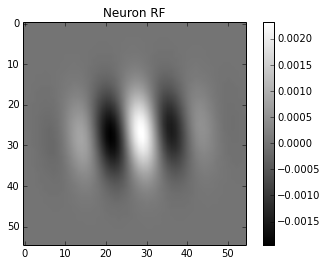

In [224]:
n_samples = 20
orientations = np.linspace(0,np.pi,n_samples)
contrasts = np.linspace(0,1,n_samples)
phases = np.linspace(0,2*np.pi,n_samples)
stims = np.zeros((n_samples,n_samples,n_samples,55,55))
responses = np.zeros((n_samples,n_samples,n_samples))
currents = np.zeros((n_samples,n_samples,n_samples))

i = 0
xi = int(r_units[i,0])
yi = int(r_units[i,1])

selected_unit = RF_layer.get_unit(xi,yi)
selected_unit.show_RF()

for i in range(n_samples):
    for j in range(n_samples):
        for k in range(n_samples):
            stims[i,j,k,:,:] = rf_lif.generate_static_grating(orientations[i], 1., 4, pix_deg=55, contrast=contrasts[k], phi=phases[k], masked=False, norm=True)
            a,J = selected_unit.get_LIF_response_rate( stims[i,j,k] )
            
            responses[i,j,k] = a
            currents[i,j,k] = J


8


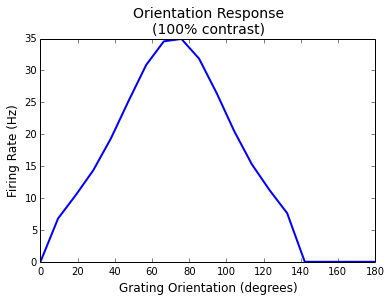

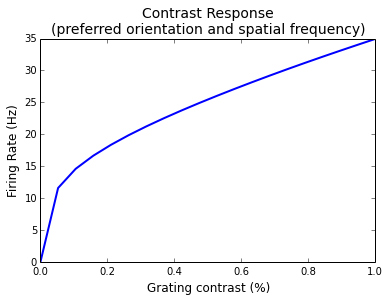

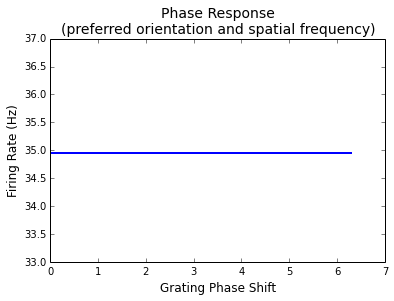

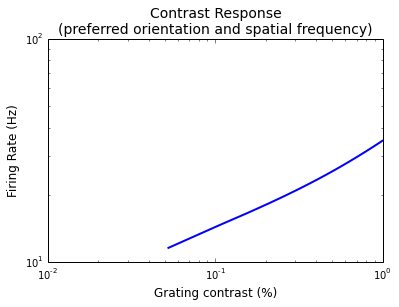

In [96]:
max_ori_ind = np.argmax(responses[:,0,-1],axis=0)
print max_ori_ind

plt.figure()
plt.plot(orientations*180/np.pi, responses[:,-1,-1], linewidth=2 )
plt.title('Orientation Response\n(100% contrast)', fontsize=14)
plt.ylabel('Firing Rate (Hz)', fontsize=12)
plt.xlabel('Grating Orientation (degrees)', fontsize=12)
plt.savefig('thesis_results/model_ori_resp.eps', format='eps', dpi=1000)

plt.figure()
plt.plot(contrasts, responses[max_ori_ind,0,:], linewidth=2 )
plt.title('Contrast Response\n(preferred orientation and spatial frequency)', fontsize=14)
plt.ylabel('Firing Rate (Hz)', fontsize=12)
plt.xlabel('Grating contrast (%)', fontsize=12)
plt.savefig('thesis_results/model_contrast_resp.eps', format='eps', dpi=1000)

plt.figure()
plt.plot(phases, responses[max_ori_ind,:,-1], linewidth=2 )
plt.title('Phase Response\n(preferred orientation and spatial frequency)', fontsize=14)
plt.xlabel('Grating Phase Shift', fontsize=12)
plt.ylabel('Firing Rate (Hz)', fontsize=12)
plt.savefig('thesis_results/model_phase_resp.eps', format='eps', dpi=1000)


plt.figure()
data = np.array([[1.52,2.80]
                [1.83,6.08],
                [2.44,11.62],
                [3.05,17.67],
                [3.95,25.22]
                [5.00,36.44],
                [6.73,52.66],
                [8.62,66.16],
                [11.46,78.00],
                [18.80,91.90],
                [32.42,98.89],
                [56.58,100.0],
                [100, 100]])

data_x = data[:,0]/100
data_y = data[:,1]/100*22
plt.loglog(contrasts, responses[max_ori_ind,0,:], linewidth=2 )
plt.loglog(data_x,data_y,'r')
plt.title('Contrast Response\n(preferred orientation and spatial frequency)', fontsize=14)
plt.ylabel('Firing Rate (Hz)', fontsize=12)
plt.xlabel('Grating contrast (%)', fontsize=12)

# plt.figure()
# plt.plot(orientations, currents[:,-1,-1] )
# plt.title('Orientation Current')

# plt.figure()
# plt.plot(contrasts, currents[0,0,:] )
# plt.title('Contrast Current')

# plt.figure()
# plt.plot(phases, currents[0,:,-1] )
# plt.title('Phase Current')

In [60]:
# generate RF layer responses for size tuning:
stim_sizes = np.linspace(1,2*16./3.,10)
rf_output = np.zeros((len(r_units), len(stim_sizes), N_pairs, N_pairs))

for i in range(len(r_units)):
    for j in range(len(stim_sizes)):
        stim_size = 75*stim_sizes[j]/16
        xi = r_units[i,0]
        yi = r_units[i,1]
        pix_deg = 55
        xpos = xi-37
        ypos = yi-37
        raw_img = rf_lif.generate_static_grating(OP_map[yi,xi]*np.pi/180, 75., 4*75, pix_deg=pix_deg, contrast=0.5, phi=0, masked=True, mask_size=stim_size, norm=True, mask_pos=[xpos,ypos])
        rf_output[i,j,:,:] = RF_layer.get_layer_response_rates(raw_img, phase_invariant=True)

[ 65.  58.]
0


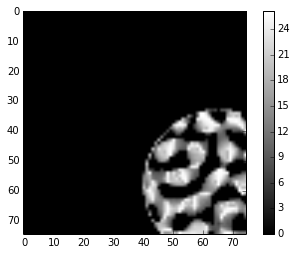

In [61]:
print r_units[i]

plt.figure()
plt.imshow(rf_output[i,j,:,:], cmap='gray')
plt.colorbar()

print len(np.where(np.isnan(rf_output))[0])

In [62]:
# Run simulations for size tuning results - coarsely probe size space 
size_tuning_results = np.zeros((n_units, len(stim_sizes), 2))

for i in range(n_units):
    xi = r_units[i,0]
    yi = r_units[i,1]
    ori = OP_map[yi,xi]
    for j in range(len(stim_sizes)):
        h0 = rf_output[i,j,:,:]
        c0 = 1
        for t in range(timesteps):
            euler(dt0,c0,h0,W_EE0,W_EI0,W_IE0,W_II0,n_E0,n_I0,k0,tau_E0,tau_I0)
            
        if np.any(np.isnan(r_I.get_value())):
            print "aw fuck"
            break

        size_tuning_results[i,j,0] = r_E.get_value()[yi,xi]
        size_tuning_results[i,j,1] = r_I.get_value()[yi,xi] 
        r_E.set_value(np.zeros((N_pairs,N_pairs),dtype='float32'))
        r_I.set_value(np.zeros((N_pairs,N_pairs),dtype='float32'))

In [74]:
r_max_E = np.max(size_tuning_results[:,:,0],1)
r_max_I = np.max(size_tuning_results[:,:,1],1)

#r_full_E = np.zeros(n_units)
#r_full_I = np.zeros(n_units)

#for i in range(n_units):
#    xi = r_units[i,0]
#    yi = r_units[i,1]
#    r_full_E[i] = rf_contrast_results[i,con_ind,0,yi,xi]
#    r_full_I[i] = rf_contrast_results[i,con_ind,1,yi,xi]

SSI_E = (r_max_E - r_full_E)/r_max_E
SSI_I = (r_max_I - r_full_I)/r_max_I
 
print "No. of E units showing strong suppression: ", len(np.where(SSI_E>0.25)[0])
print "No. of I units showing strong suppression: ", len(np.where(SSI_I>0.25)[0])
 
# Select just the units which showed strong surround suppresion (SSI > .25)
r_SS_E = np.squeeze(size_tuning_results[np.where(SSI_E>0.25),:,0])
r_SS_I = np.squeeze(size_tuning_results[np.where(SSI_I>0.25),:,1])
print r_SS_E.shape

No. of E units showing strong suppression:  40
No. of I units showing strong suppression:  17
(40, 10)


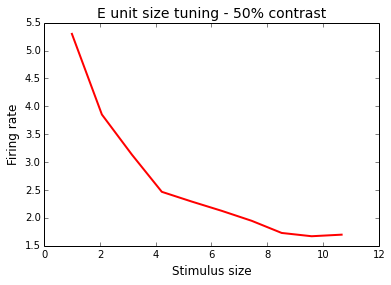

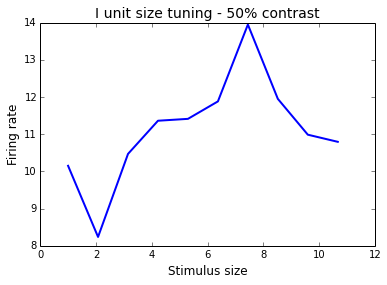

In [76]:
plt.figure()
plt.title("E unit size tuning - 50% contrast" , fontsize=14)
plt.xlabel("Stimulus size", fontsize=12)
plt.ylabel("Firing rate", fontsize=12)
plt.plot(stim_sizes, np.mean(r_SS_E,0), 'r', linewidth=2)
plt.savefig('thesis_results/E_size_tuning_kaschube_map.eps', format='eps', dpi=1000)

plt.figure()
plt.title("I unit size tuning - 50% contrast", fontsize=14)
plt.xlabel("Stimulus size", fontsize=12)
plt.ylabel("Firing rate", fontsize=12)
plt.plot(stim_sizes, np.mean(r_SS_I,0), 'b', linewidth=2)
plt.savefig('thesis_results/I_size_tuning_kaschube_map.eps', format='eps', dpi=1000)

In [73]:
# if we need to run more full field sims for other 'r_units'
r_full_E = np.zeros(n_units)
r_full_I = np.zeros(n_units)

for i in range(n_units):
    xi = r_units[i,0]
    yi = r_units[i,1]
    pix_deg = 55
    xpos = xi-37
    ypos = yi-37
    raw_img = rf_lif.generate_static_grating(OP_map[yi,xi]*np.pi/180, 75., 4*75, pix_deg=pix_deg, contrast=0.5, phi=0, masked=True, mask_size=75, norm=True, mask_pos=[xpos,ypos])
    h_rf = RF_layer.get_layer_response_rates(raw_img, phase_invariant=True)
    c0 = 1
    for t in range(timesteps):
        euler(dt0,c0,h_rf,W_EE0,W_EI0,W_IE0,W_II0,n_E0,n_I0,k0,tau_E0,tau_I0)
            
    r_full_E[i] = r_E.get_value()[yi,xi]
    r_full_I[i] = r_I.get_value()[yi,xi] 
    r_E.set_value(np.zeros((N_pairs,N_pairs),dtype='float32'))
    r_I.set_value(np.zeros((N_pairs,N_pairs),dtype='float32'))

# Surround suppression dependence on centre stimulus strength
### Reproduction of figure 6H of Rubin et al. 2015

unit coords: 2,68
OP map value:  151.0
Showing RF!
RF unit theta:  2.63544717051


NameError: name 'sfs_sizes' is not defined

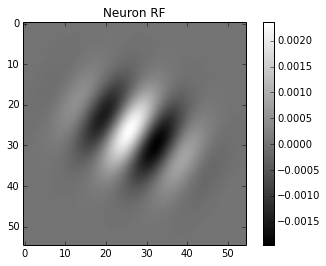

In [13]:
xi = r_units[0,0]
yi = r_units[0,1]

print "unit coords: %d,%d" %(xi,yi)
print "OP map value: ", OP_map[yi,xi]

selected_unit = RF_layer.get_unit(int(yi),int(xi))
RF_layer.get_unit(int(yi),int(xi)).show_RF()
print "RF unit theta: ", selected_unit.theta

i = 0
j = 0
stim_size = 75*sfs_sizes[j]/16.
raw_img = rf_lif.generate_static_grating(OP_map[yi,xi]*np.pi/180, 75., 4*75, pix_deg=pix_deg, contrast=centre_stim_c[i], phi=0, masked=True, mask_size=stim_size, norm=True, mask_pos=[xpos,ypos])
h_rf = RF_layer.get_layer_response_rates(raw_img)
c0 = 1
plt.figure()
plt.imshow(raw_img, cmap='gray')

plt.figure()
plt.imshow(h_rf, cmap='gray')

for t in range(timesteps):
    euler(dt0,c0,h_rf,W_EE0,W_EI0,W_IE0,W_II0,n_E0,n_I0,k0,tau_E0,tau_I0)
    
plt.figure()
img_segment = raw_img[yi*RF_layer.rf_size_pix:yi*RF_layer.rf_size_pix+RF_layer.rf_size_pix, xi*RF_layer.rf_size_pix:xi*RF_layer.rf_size_pix+RF_layer.rf_size_pix]
plt.imshow(img_segment, cmap='gray')
plt.title("segment of image")
plt.colorbar()

result_E = r_E.get_value()[yi,xi]
result_I = r_I.get_value()[yi,xi] 
r_E.set_value(np.zeros((N_pairs,N_pairs),dtype='float32'))
r_I.set_value(np.zeros((N_pairs,N_pairs),dtype='float32'))

print h_rf[yi,xi]
print result_E

In [17]:
centre_stim_c = np.linspace(0.05,1,25)
surround_sizes = np.array([1.5,2,3,4,8,12])
cent_surr_results = np.zeros((len(surround_sizes)+1, len(centre_stim_c) ))

sum_field_sizes = np.zeros(len(centre_stim_c))
max_frs = np.zeros(len(centre_stim_c))

selected_unit = r_units[0]

xi = selected_unit[0]
yi = selected_unit[1]
xpos = xi-37
ypos = yi-37
pix_deg = 55
sfs_sizes = np.linspace(0.5,5,20)
for i in range(len(centre_stim_c)):
    max_fr = 0
    
    for j in range(len(sfs_sizes)):
        stim_size = 75*sfs_sizes[j]/16.
        raw_img = rf_lif.generate_static_grating(OP_map[yi,xi]*np.pi/180, 75., 4*75, pix_deg=pix_deg, contrast=centre_stim_c[i], phi=0, masked=True, mask_size=stim_size, norm=True, mask_pos=[xpos,ypos])
        h_rf = RF_layer.get_layer_response_rates(raw_img)

        for t in range(timesteps):
            euler(dt0,1,h_rf,W_EE0,W_EI0,W_IE0,W_II0,n_E0,n_I0,k0,tau_E0,tau_I0)
        
        result_E = r_E.get_value()[yi,xi]
        result_I = r_I.get_value()[yi,xi] 
        r_E.set_value(np.zeros((N_pairs,N_pairs),dtype='float32'))
        r_I.set_value(np.zeros((N_pairs,N_pairs),dtype='float32'))
        
        if result_E > max_frs[i]:
            max_frs[i] = result_E
            sum_field_sizes[i] = sfs_sizes[j]
        else:
            break

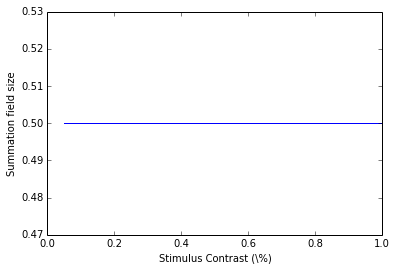

In [19]:
# plot summation field sizes against contrast:
plt.figure()
plt.plot(centre_stim_c, sum_field_sizes)
plt.xlabel("Stimulus Contrast (%)")
plt.ylabel("Summation field size")

In [31]:
# run simulations for centre with surrounds of increasing size
cent_surr_results[0,j] = max_frs

for i in range(len(surround_sizes)):
    
    for j in range(len(centre_stim_c)):
        centre_img = rf_lif.generate_static_grating(OP_map[yi,xi]*np.pi/180, 75., 4*75, pix_deg=pix_deg, contrast=centre_stim_c[j], phi=0, masked=True, mask_size=75*sum_field_sizes[j]/16., norm=True, mask_pos=[xpos,ypos])
        surround_img = rf_lif.generate_ring_grating(OP_map[yi,xi]*np.pi/180, 75., 4*75, pix_deg=pix_deg, contrast=1., phi=0, inner_d=75*sum_field_sizes[j]/16., outer_d=75*surround_sizes[i]/16., norm=True, mask_pos=[xpos,ypos])
        h_rf = RF_layer.get_layer_response_rates(centre_img+surround_img)
        
        for t in range(timesteps):
            euler(dt0,1,h_rf,W_EE0,W_EI0,W_IE0,W_II0,n_E0,n_I0,k0,tau_E0,tau_I0)
        
        cent_surr_results[i+1,j] = r_E.get_value()[yi,xi]
        r_E.set_value(np.zeros((N_pairs,N_pairs),dtype='float32'))
        r_I.set_value(np.zeros((N_pairs,N_pairs),dtype='float32'))

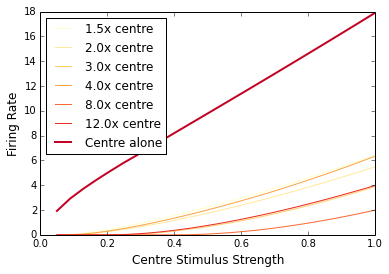

In [32]:
fig = plt.figure()

NUM_COLORS = len(cent_surr_results)
cm = plt.get_cmap('YlOrRd')
ax = fig.add_subplot(111)
ax.set_color_cycle([cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])

for i in range(len(surround_sizes)):
    ax.plot(centre_stim_c, cent_surr_results[i+1,:], label="%2.1fx centre" % (surround_sizes[i]))

ax.plot(centre_stim_c, cent_surr_results[0,:], label="Centre alone", linewidth=2)

plt.legend(loc='best')
plt.xlabel('Centre Stimulus Strength', fontsize=12)
plt.ylabel('Firing Rate', fontsize=12)
# plt.savefig('thesis_results/surround_contrast.eps', format='eps', dpi=1000)

2.34375


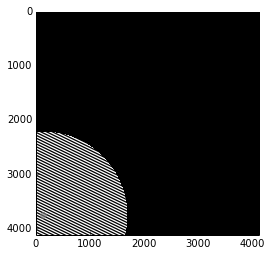

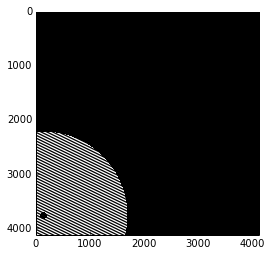

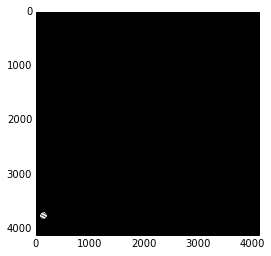

In [30]:
centre_img = rf_lif.generate_static_grating(OP_map[yi,xi]*np.pi/180, 75., 4*75, pix_deg=pix_deg, contrast=0.25, phi=0, masked=True, mask_size=75*4/16., norm=True, mask_pos=[0,0])
surround_img = rf_lif.generate_ring_grating(OP_map[yi,xi]*np.pi/180, 75., 4*75, pix_deg=pix_deg, contrast=1., phi=0, inner_d=75*4/16., outer_d=75*8/16., norm=True, mask_pos=[0,0])
plt.figure()
plt.imshow(centre_img+surround_img, cmap='gray')
plt.axis('off')
plt.savefig('thesis_results/sample_contrast_surround_stimuli.png', format='png', dpi=50)

plt.figure()
plt.imshow(surround_img, cmap='gray')

plt.figure()
plt.imshow(centre_img, cmap='gray')

# Orientation tuning of surround suppression
### Reproduction of figure 7D, Rubin et al 2015

In [79]:
surround_ori_diff = np.linspace(-80*np.pi/180,80*np.pi/180,10)
ori_surround_results = np.zeros((n_units, 2, len(surround_ori_diff)+1))

sfs_size = 75*1.5/16.

for i in range(n_units):
    xi = r_units[i,0]
    yi = r_units[i,1]
    centre_ori = OP_map[yi,xi]*np.pi/180
    centre_stim = rf_lif.generate_static_grating(centre_ori, 75., 4*75, pix_deg=pix_deg, contrast=0.5, phi=0, masked=True, mask_size=sfs_size, norm=True, mask_pos=[xi-37,yi-37])
    h_centre = RF_layer.get_layer_response_rates(centre_stim)
        
    for t in range(timesteps):
        euler(dt0,1,h_centre,W_EE0,W_EI0,W_IE0,W_II0,n_E0,n_I0,k0,tau_E0,tau_I0)

    ori_surround_results[i,0,-1] = r_E.get_value()[yi,xi]
    ori_surround_results[i,1,-1] = r_I.get_value()[yi,xi]
    r_E.set_value(np.zeros((N_pairs,N_pairs),dtype='float32'))
    r_I.set_value(np.zeros((N_pairs,N_pairs),dtype='float32'))
    
    for j in range(len(surround_ori_diff)):
        surround_stim = rf_lif.generate_ring_grating(centre_ori+surround_ori_diff[j], 75., 4*75, pix_deg=pix_deg, contrast=0.5, phi=0, inner_d=sfs_size, outer_d=75*15.1/16., norm=True, mask_pos=[xi-37,yi-37])
        h_rf = RF_layer.get_layer_response_rates(centre_stim+surround_stim)
        
        for t in range(timesteps):
            euler(dt0,1,h_rf,W_EE0,W_EI0,W_IE0,W_II0,n_E0,n_I0,k0,tau_E0,tau_I0)
        
        ori_surround_results[i,0,j] = r_E.get_value()[yi,xi]
        ori_surround_results[i,1,j] = r_I.get_value()[yi,xi]
        r_E.set_value(np.zeros((N_pairs,N_pairs),dtype='float32'))
        r_I.set_value(np.zeros((N_pairs,N_pairs),dtype='float32'))

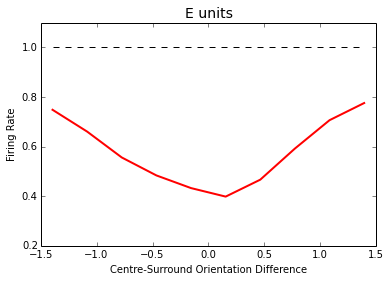

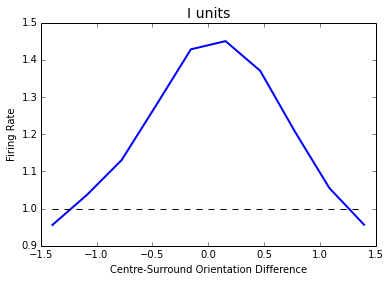

In [86]:
# plot results:

norm_ori_surround_results = np.zeros((n_units, 2, len(surround_ori_diff)))

for i in range(n_units):
    norm_ori_surround_results[i,0,:] = ori_surround_results[i,0,:-1]/ori_surround_results[i,0,-1]
    norm_ori_surround_results[i,1,:] = ori_surround_results[i,1,:-1]/ori_surround_results[i,1,-1]

plt.figure()
plt.plot(surround_ori_diff, np.mean(norm_ori_surround_results[:,0,:],0), 'r', linewidth=2 )
plt.plot(surround_ori_diff, np.ones(len(surround_ori_diff)), 'k--')
plt.title('E units', fontsize=14)
plt.xlabel('Centre-Surround Orientation Difference')
plt.ylabel('Firing Rate')
plt.ylim([0.2,1.1])
plt.savefig('thesis_results/surround_ori_tuning_E.eps', format='eps', dpi=1000)

plt.figure()
plt.plot(surround_ori_diff, np.mean(norm_ori_surround_results[:,1,:],0), 'b', linewidth=2 )
plt.plot(surround_ori_diff, np.ones(len(surround_ori_diff)), 'k--')
plt.title('I units', fontsize=14)
plt.xlabel('Centre-Surround Orientation Difference')
plt.ylabel('Firing Rate')
plt.savefig('thesis_results/surround_ori_tuning_I.eps', format='eps', dpi=1000)

# Orientation tuning of surround suppression
### Let's see if we can reproduce the figure using the original SSN input function

In [108]:
# First find SFS for each unit, both E and I:

# probe the monocular size tuning for the selected units and # find the SFS for each unit:
sfs_E = np.zeros(n_units)
sfs_I = np.copy(sfs_E)
sfs_fr_E = np.zeros(n_units)
sfs_fr_I = np.copy(sfs_fr_E)
stim_sizes = np.linspace(0.5,2,10)
st = time.time()
for i in range(n_units):
    sfs_found_E = False
    sfs_found_I = False
    xi = r_units[i,0]
    yi = r_units[i,1]
    ori = OP_map[yi,xi]
    for j in range(len(stim_sizes)):
        h0 = ssn.generate_mono_stimulus( ori, stim_sizes[j], [dx*xi, dx*yi], OP_map )
        for t in range(timesteps):
            euler(dt0,40,h0,W_EE0,W_EI0,W_IE0,W_II0,n_E0,n_I0,k0,tau_E0,tau_I0)

        E_result = r_E.get_value()[yi,xi]
        I_result = r_I.get_value()[yi,xi] 
        r_E.set_value(np.zeros((N_pairs,N_pairs),dtype='float32'))
        r_I.set_value(np.zeros((N_pairs,N_pairs),dtype='float32'))

        # check to see if any of the rates overflowed:
        if E_result>1000 or np.isnan(E_result):
            print "Network unstable, skipping!"
            
        if E_result > sfs_fr_E[i]:
            sfs_fr_E[i] = E_result
            sfs_E[i] = stim_sizes[j]
        else:
            sfs_found_E = True

        if I_result > sfs_fr_I[i]:
            sfs_fr_I[i] = I_result
            sfs_I[i] = stim_sizes[j]
        else:
            sfs_found_I = True

        if sfs_found_E and sfs_found_I:
            break
print "Elapsed time: %d seconds." % (time.time() - st)

Elapsed time: 3539 seconds.


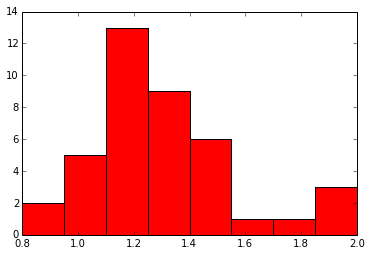

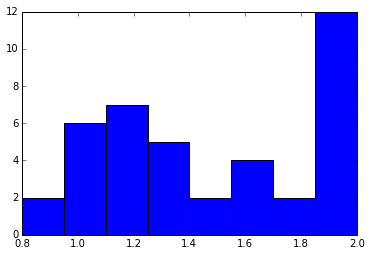

In [109]:
# Plot histograms of the summation field sizes:
plt.figure()
plt.hist(sfs_E, bins=10, range=(0.5, 2), fc='r', ec='k')
plt.savefig('thesis_results/sfs_E_histogram_fine.png', dpi=100)

plt.figure()
plt.hist(sfs_I, bins=10, range=(0.5, 2), fc='b', ec='k')
plt.savefig('thesis_results/sfs_I_histogram_fine.png', dpi=100)

In [111]:
surround_ori_diff_deg = np.linspace(-80,80,10)
ori_surround_results_SSN = np.zeros((n_units, 2, len(surround_ori_diff)+1))

ori_surround_results_SSN[:,0,-1] = sfs_fr_E
ori_surround_results_SSN[:,1,-1] = sfs_fr_I

st = time.time()
for i in range(n_units):
    xi = r_units[i,0]
    yi = r_units[i,1]
    centre_ori = OP_map[yi,xi]
    h_centre_E = ssn.generate_mono_stimulus(centre_ori, sfs_E[i], [xi*dx,yi*dx], OP_map)
    
    for j in range(len(surround_ori_diff_deg)):
        surround_ori = centre_ori + surround_ori_diff_deg[j]
        h_surround = ssn.generate_ring_stimulus(surround_ori, inner_d=sfs_E[i], outer_d=15.1, centre=[xi*dx,yi*dx], ocularity=0, OP_map=OP_map, mono=True)
        h_rf = h_centre_E + h_surround
        
        for t in range(timesteps):
            euler(dt0,40,h_rf,W_EE0,W_EI0,W_IE0,W_II0,n_E0,n_I0,k0,tau_E0,tau_I0)
        
        ori_surround_results_SSN[i,0,j] = r_E.get_value()[yi,xi]
        
        if sfs_E[i]==sfs_I[i]:
            ori_surround_results_SSN[i,1,j] = r_I.get_value()[yi,xi]
            r_E.set_value(np.zeros((N_pairs,N_pairs),dtype='float32'))
            r_I.set_value(np.zeros((N_pairs,N_pairs),dtype='float32'))
        else:
            r_E.set_value(np.zeros((N_pairs,N_pairs),dtype='float32'))
            r_I.set_value(np.zeros((N_pairs,N_pairs),dtype='float32'))
            
            h_centre_I = ssn.generate_mono_stimulus(centre_ori, sfs_I[i], [xi*dx,yi*dx], OP_map)
            h_surround = ssn.generate_ring_stimulus(surround_ori, inner_d=sfs_I[i], outer_d=15.1, centre=[xi*dx,yi*dx], ocularity=0, OP_map=OP_map, mono=True)
            h_rf = h_centre_I + h_surround

            for t in range(timesteps):
                euler(dt0,40,h_rf,W_EE0,W_EI0,W_IE0,W_II0,n_E0,n_I0,k0,tau_E0,tau_I0)
                
            ori_surround_results_SSN[i,1,j] = r_I.get_value()[yi,xi]
            r_E.set_value(np.zeros((N_pairs,N_pairs),dtype='float32'))
            r_I.set_value(np.zeros((N_pairs,N_pairs),dtype='float32'))
        
print "Elapsed time: %d seconds." % (time.time()-st)

Elapsed time: 7995 seconds.


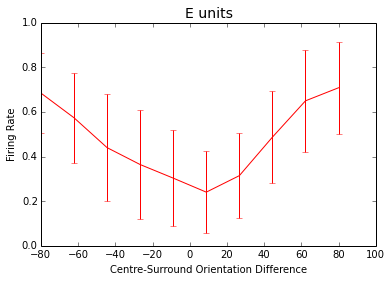

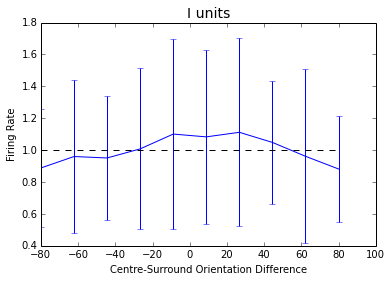

In [138]:
# plot results:

norm_ori_surround_results_SSN = np.zeros((n_units, 2, len(surround_ori_diff_deg)))

for i in range(n_units):
    norm_ori_surround_results_SSN[i,0,:] = ori_surround_results_SSN[i,0,:-1]/ori_surround_results_SSN[i,0,-1]
    norm_ori_surround_results_SSN[i,1,:] = ori_surround_results_SSN[i,1,:-1]/ori_surround_results_SSN[i,1,-1]

plt.figure()
# plt.plot(surround_ori_diff_deg, np.mean(norm_ori_surround_results_SSN[:,0,:],0), 'r', linewidth=2 )
plt.errorbar(surround_ori_diff_deg, np.mean(norm_ori_surround_results_SSN[:,0,:],0), np.std(norm_ori_surround_results_SSN[:,0,:],0), fmt='r')
plt.plot(surround_ori_diff_deg, np.ones(len(surround_ori_diff_deg)), 'k--')
plt.title('E units', fontsize=14)
plt.xlabel('Centre-Surround Orientation Difference')
plt.ylabel('Firing Rate')
plt.savefig('thesis_results/ssn_ori_suppression_E_fine_sfs.png', dpi=100)
# plt.ylim([0.2,1.1])

plt.figure()
# plt.plot(surround_ori_diff_deg, np.mean(norm_ori_surround_results_SSN[:,1,:],0), 'b', linewidth=2 )
plt.errorbar(surround_ori_diff_deg, np.mean(norm_ori_surround_results_SSN[:,1,:],0), np.std(norm_ori_surround_results_SSN[:,1,:],0), fmt='b')
plt.plot(surround_ori_diff_deg, np.ones(len(surround_ori_diff_deg)), 'k--')
plt.title('I units', fontsize=14)
plt.xlabel('Centre-Surround Orientation Difference')
plt.ylabel('Firing Rate')
plt.savefig('thesis_results/ssn_ori_suppression_I_fine_sfs.png', dpi=100)

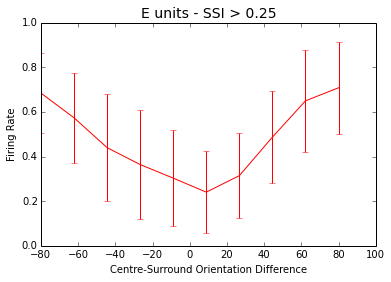

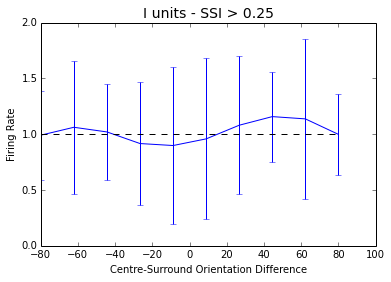

In [137]:
norm_SSI_E = np.zeros((len(np.where(SSI_E>0.25)[0]), len(surround_ori_diff_deg)))
norm_SSI_I = np.zeros((len(np.where(SSI_I>0.25)[0]), len(surround_ori_diff_deg)))

SSI_results_E = np.squeeze(ori_surround_results_SSN[np.where(SSI_E>0.25),0,:])
SSI_results_I = np.squeeze(ori_surround_results_SSN[np.where(SSI_I>0.25),1,:])

for i in range(len(norm_SSI_E)):
    norm_SSI_E[i,:] = SSI_results_E[i,:-1]/SSI_results_E[i,-1]

for i in range(len(norm_SSI_I)):    
    norm_SSI_I[i,:] = SSI_results_I[i,:-1]/SSI_results_I[i,-1]
    
plt.figure()
# plt.plot(surround_ori_diff_deg, np.mean(norm_ori_surround_results_SSN[:,0,:],0), 'r', linewidth=2 )
plt.errorbar(surround_ori_diff_deg, np.mean(norm_SSI_E,0), np.std(norm_SSI_E,0), fmt='r')
plt.plot(surround_ori_diff_deg, np.ones(len(surround_ori_diff_deg)), 'k--')
plt.title('E units - SSI > 0.25', fontsize=14)
plt.xlabel('Centre-Surround Orientation Difference')
plt.ylabel('Firing Rate')
plt.savefig('thesis_results/ssn_ori_suppression_E_SSI.png', dpi=100)
# plt.ylim([0.2,1.1])

plt.figure()
# plt.plot(surround_ori_diff_deg, np.mean(norm_ori_surround_results_SSN[:,1,:],0), 'b', linewidth=2 )
plt.errorbar(surround_ori_diff_deg, np.mean(norm_SSI_I,0), np.std(norm_SSI_I,0), fmt='b')
plt.plot(surround_ori_diff_deg, np.ones(len(surround_ori_diff_deg)), 'k--')
plt.title('I units - SSI > 0.25', fontsize=14)
plt.xlabel('Centre-Surround Orientation Difference')
plt.ylabel('Firing Rate')
plt.savefig('thesis_results/ssn_ori_suppression_I_SSI.png', dpi=100)

In [119]:
print ori_surround_results.shape
print SSI_results_E.shape
print np.where(SSI_E>0.25)

(40, 2, 11)
(1, 40, 11)
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39]),)


22


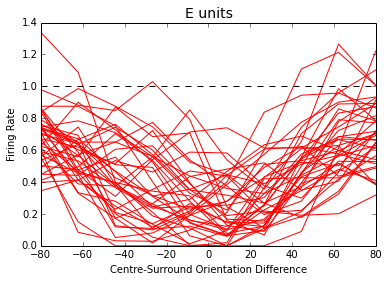

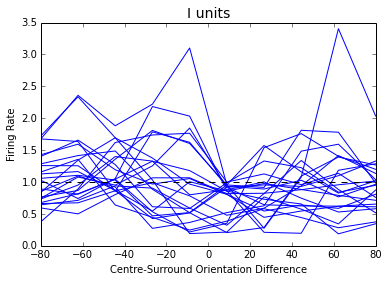

In [122]:
plt.figure()
for i in range(n_units):
    plt.plot(surround_ori_diff_deg, norm_ori_surround_results_SSN[i,0,:], 'r', linewidth=1 )
plt.plot(surround_ori_diff_deg, np.ones(len(surround_ori_diff_deg)), 'k--')
plt.title('E units', fontsize=14)
plt.xlabel('Centre-Surround Orientation Difference')
plt.ylabel('Firing Rate')
# plt.savefig('thesis_results/ssn_ori_suppression_E_fine_sfs.png', dpi=100)
# plt.ylim([0.2,1.1])

plt.figure()
count = 0
for i in range(n_units):
    if norm_ori_surround_results_SSN[i,1,5] < 1:
        count = count + 1
        plt.plot(surround_ori_diff_deg, norm_ori_surround_results_SSN[i,1,:], 'b', linewidth=1 )
plt.plot(surround_ori_diff_deg, np.ones(len(surround_ori_diff_deg)), 'k--')
plt.title('I units', fontsize=14)
plt.xlabel('Centre-Surround Orientation Difference')
plt.ylabel('Firing Rate')
# plt.savefig('thesis_results/ssn_ori_suppression_I_fine_sfs.png', dpi=100)
print count

In [132]:
# Examine the timeseries to ensure things are steady-state:

total_time = 0.5
dt0 = 0.001
timesteps = int(total_time/dt0)

surround_results_E_t = np.zeros((timesteps, N_pairs, N_pairs))
surround_results_I_t = np.zeros((timesteps, N_pairs, N_pairs))

i = 0
j = 5

xi = r_units[i,0]
yi = r_units[i,1]
centre_ori = OP_map[yi,xi]
h_centre_E = ssn.generate_mono_stimulus(centre_ori, sfs_E[i], [xi*dx,yi*dx], OP_map)

surround_ori = centre_ori + surround_ori_diff_deg[j]
h_surround = ssn.generate_ring_stimulus(surround_ori, inner_d=sfs_E[i], outer_d=15.1, centre=[xi*dx,yi*dx], ocularity=0, OP_map=OP_map, mono=True)
h_rf = h_centre_E + h_surround

for t in range(timesteps):
    euler(dt0,40,h_rf,W_EE0,W_EI0,W_IE0,W_II0,n_E0,n_I0,k0,tau_E0,tau_I0)
    surround_results_E_t[t,:,:] = r_E.get_value()
    surround_results_I_t[t,:,:] = r_I.get_value()

r_E.set_value(np.zeros((N_pairs,N_pairs),dtype='float32'))
r_I.set_value(np.zeros((N_pairs,N_pairs),dtype='float32'))

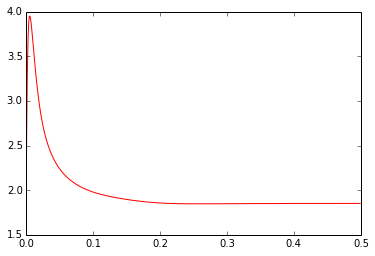

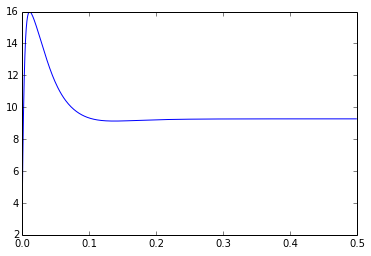

In [133]:
plt.figure()
plt.plot(np.linspace(0,0.5,timesteps, endpoint=False), surround_results_E_t[:,yi,xi], 'r')

plt.figure()
plt.plot(np.linspace(0,0.5,timesteps, endpoint=False), surround_results_I_t[:,yi,xi], 'b')

In [134]:
diff_E = surround_results_E_t[-1] - surround_results_E_t[-2]
print np.where(np.abs(diff_E)>0.1)

diff_I = surround_results_I_t[-1] - surround_results_I_t[-2]
print np.where(np.abs(diff_I)>0.1)

(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))


151.0
159.888888889


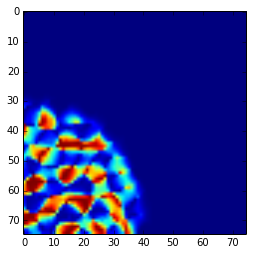

In [136]:
plt.imshow(h_rf)
print centre_ori
print surround_ori

In [141]:
size_tuning_stim_sizes = np.linspace(1,2*16./3.,10)

r_max_ind_E = np.argmax(size_tuning_results[:,:,0],1)
r_max_ind_I = np.argmax(size_tuning_results[:,:,1],1)
for i in range(len(r_max_ind_I)):
    if SSI_I[i] > 0.25:
        print size_tuning_stim_sizes[r_max_ind_I[i]]

9.59259259259
5.2962962963
1.0
8.51851851852
6.37037037037
7.44444444444
3.14814814815
7.44444444444
7.44444444444
3.14814814815
4.22222222222
1.0
1.0
1.0
3.14814814815
1.0
7.44444444444
